In [1]:
import glob
import matplotlib.pyplot as pyplot
%matplotlib inline
import numpy
import pprint
import sklearn.preprocessing
import subprocess
import sys
import time
import os
import pip
#pip.main(['install', '--user', 'seaborn'])
#pip.main(['install', '--user', 'pyspark'])

# These add search paths to the PYTHONPATH inorder to find pydarshan and pyspark
# pyDarshan
sys.path.append("/u/eot/borcean2/apps/pydarshan/darshan-autoperf-mod-9357d7f98b263f60a02bdec1dfec0f45bfa2beee/darshan-util")

#pyspark
sys.path.append("/mnt/a/u/eot/borcean2/.local/lib/python3.5/site-packages")
sys.path.append("/mnt/a/u/eot/borcean2/.local/lib/python3.5/site-packages/bin")
sys.path.append("/mnt/a/u/eot/borcean2/.local/lib/python3.5")
sys.path.append("/mnt/a/u/eot/borcean2/.local/lib/python3.5/site-packages/pyspark/python/lib/py4j-0.10.6-src.zip")

# sys.path.append("/u/eot/borcean2/.local/lib/python3.5/site-packages/pyspark/bin")
# sys.path.append("/u/eot/borcean2/.local/lib/python3.5/site-packages/pyspark/")
# sys.path.append("/u/eot/borcean2/.local/lib/python3.5/")
# sys.path.append("./.local/lib/python3.5/site-packages/pyspark/python/lib/py4j-0.10.6pwd-src.zip")

import pydarshan
import pyspark
#print (pydarshan.__file__)
#print (pyspark.__file__)


In [7]:
def collect_logs(path):
    return glob.glob("{0}/*.darshan".format(path))

In [8]:
def find_master(path):
    f = open("{0}/master".format(path))
    master = f.read()
    f.close()
    return master[:-1]

In [9]:
def start_spark():
    cmd = ["sh","/mnt/a/u/eot/borcean2/spark.sh"]
    jid = subprocess.check_output(cmd)
    jobid = jid.decode("utf-8")[:-1]
    cmd = ["qstat", "--header", "State", jobid]
    once = True
    while True:
        out = subprocess.check_output(cmd)
        lines = out.decode("utf-8").split('\n')
        state = lines[2].strip()
        if state == 'running':
            break
        else:
            if once: print("Waiting"); once=False
            print("\tjobid: {jobid} state: {state}".format(jobid=jobid, state=state))
        time.sleep(60) # cobalt can easily be DOS'd with a high command issue rate
    return jobid

In [10]:
def stop_spark(jobid):
    cmd = ["qdel", jobid]
    ret = subprocess.call(cmd)
    return ret

In [11]:
def process_log(logname):
    log = pydarshan.log_open(logname)
    exe = pydarshan.log_get_exe(log)
    mnt = pydarshan.log_get_mounts(log)
    mod = pydarshan.log_get_modules(log)
    job = pydarshan.log_get_job(log)
    bgq = pydarshan.log_get_bgq_record(log)
    n = pydarshan.counter_names("bgq")
    i = n.index('BGQ_NNODES')
    job['exe'] = exe
    job['mnt'] = mnt
    job['mod'] = mod
    job['nodes'] = bgq['counters'][i]
    job['runtime'] = int(job['end_time']) - int(job['start_time'])
    pydarshan.log_close(log)
    return job

---
# Main
---
Find the number of logs we have and then process them in parallel using Spark.

In [24]:
logs=[]
for root, dirs, files in os.walk("/mnt/a/u/eot/borcean2/logs/files/darshan/"):
    for file in files:
        if file.endswith(".darshan.gz"):
             #print(os.path.join(root, file))
             logs.append(os.path.join(root,file))
#[print(log) for x in logs]      
print("Number of TOKIO logs: {}".format(len(logs)))

Number of TOKIO logs: 1


### Launch Spark on Cooley
* qsub a job to run the spark infrastructure on the Cooley compute nodes.
* Wait for this job to start and then find which node the Spark master is running on.
* **This could take minutes to hours**

In [14]:

#master = find_master("/mnt/a/u/eot/borcean2/apps/spark/2.1.1/conf")
master = "http://10.128.42.59:8080"
#print("Job {jobid} running with Spark master on {master}".format(jobid=jobid,master=master))

In [8]:
sc=pyspark.setMaster(master)

AttributeError: module 'pyspark' has no attribute 'setMaster'

#### Connect to the Spark instance
If 'sc' is already initialized, Spark throws an error if you try to reconnect to the SparkContext. So unlike other parts of the notebook, you can not nicely rerun the cell below. If sc has been defined, the try clause will succeed and the SparkContext will not be recreated.
* **If you need to rerun this part, shutdown the notebook and start again**

In [13]:
try:
    sc = pyspark.SparkContext(master, "tokio")
    #sc.addPyFile("/u/eot/borcean2/apps/pydarshan/darshan-autoperf-mod-9357d7f98b263f60a02bdec1dfec0f45bfa2beee/darshan-util/pydarshan.py")
except:
    print("ops")
    sc = pyspark.SparkContext.getOrCreate()
if sc:
    print(sc)

ops


FileNotFoundError: [Errno 2] No such file or directory: 'http://10.128.42.59:8080/./bin/spark-submit': 'http://10.128.42.59:8080/./bin/spark-submit'

### Running Spark Code
---

In [40]:
rdd = sc.parallelize(logs)
pset = rdd.map(process_log)
results = pset.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 5.0 failed 1 times, most recent failure: Lost task 4.0 in stage 5.0 (TID 324, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/mnt/a/u/eot/borcean2/.local/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 175, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 3.5 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/mnt/a/u/eot/borcean2/.local/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 175, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 3.5 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


### Analyze Results
---

In [31]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results[0])

NameError: name 'results' is not defined

In [61]:
sorted_results = sorted(results, key=lambda k: k['start_time']) 
dset = {}
dset_stime = {}
for r in sorted_results:
    key = r['exe']
    if key in dset:
        dset[key].append(r['runtime'])
        dset_stime[key].append(int(r['start_time']))
    else:
        dset[key] = []
        dset_stime[key] = []
        dset[key].append(r['runtime'])
        dset_stime[key].append(int(r['start_time']))
print("Analyzed Stats")
for k in dset.keys():
    print("Key: ", k.replace("/projects/radix-io/automated/", ""))
    print("\titems: ", len(dset[k]))

Analyzed Stats
Key:  bin/ior -H -r -s 16 -o tmp/ior/ior-mpiio.out -f inputs/mpiio1m2.in
	items:  321
Key:  bin/ior -H -r -s 16 -o tmp/ior/ior-posix.out -f inputs/posix1m2.in
	items:  319
Key:  bin/hacc_io_write 3532026 tmp/hacc-io/hacc-io.out
	items:  6
Key:  bin/hacc_io_write 1986776 tmp/hacc-io/hacc-io.out
	items:  329
Key:  bin/hacc_io_read 1986776 tmp/hacc-io/hacc-io.out
	items:  311
Key:  bin/ior -H -k -w -s 16 -o tmp/ior/ior-posix.out -f inputs/posix1m2.in
	items:  337
Key:  bin/vpicio_uni tmp/vpic-io/vpic-io.hdf5 2
	items:  313
Key:  bin/hacc_io_read 3532026 tmp/hacc-io/hacc-io.out
	items:  6
Key:  bin/ior -H -k -w -s 16 -o tmp/ior/ior-mpiio.out -f inputs/mpiio1m2.in
	items:  338
Key:  bin/dbscan_read -d /Step#0/x -d /Step#0/y -d /Step#0/z -d /Step#0/px -d /Step#0/py -d /Step#0/pz -f tmp/vpic-io/vpic-io.hdf5
	items:  302


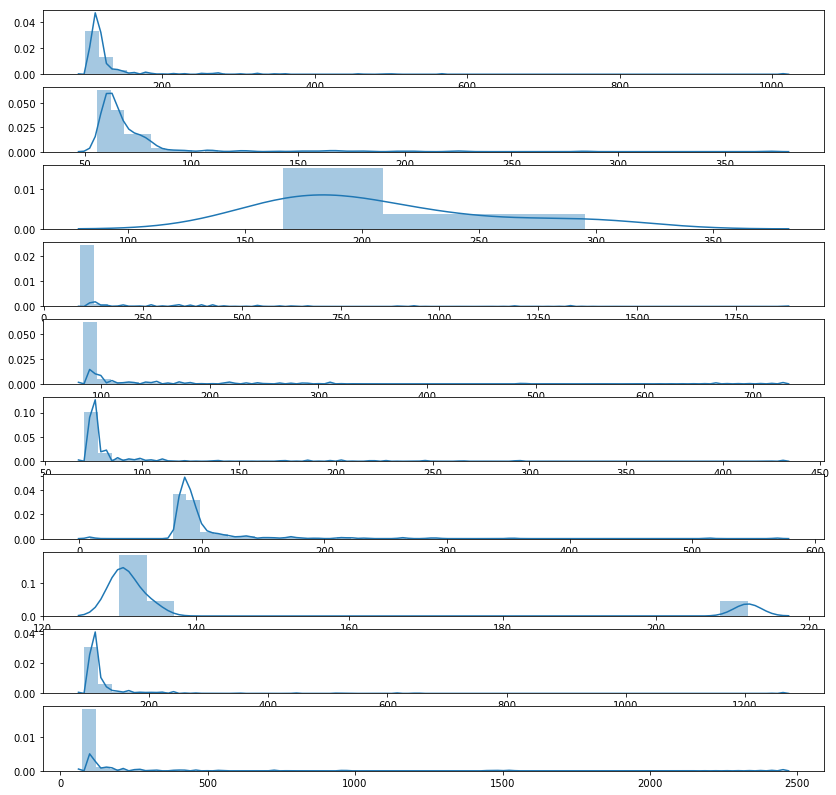

In [62]:
fig, axs = pyplot.subplots(figsize=(14,14),nrows=10)
for k, ax in zip(dset.keys(),axs):
    seaborn.distplot(dset[k], ax=ax)

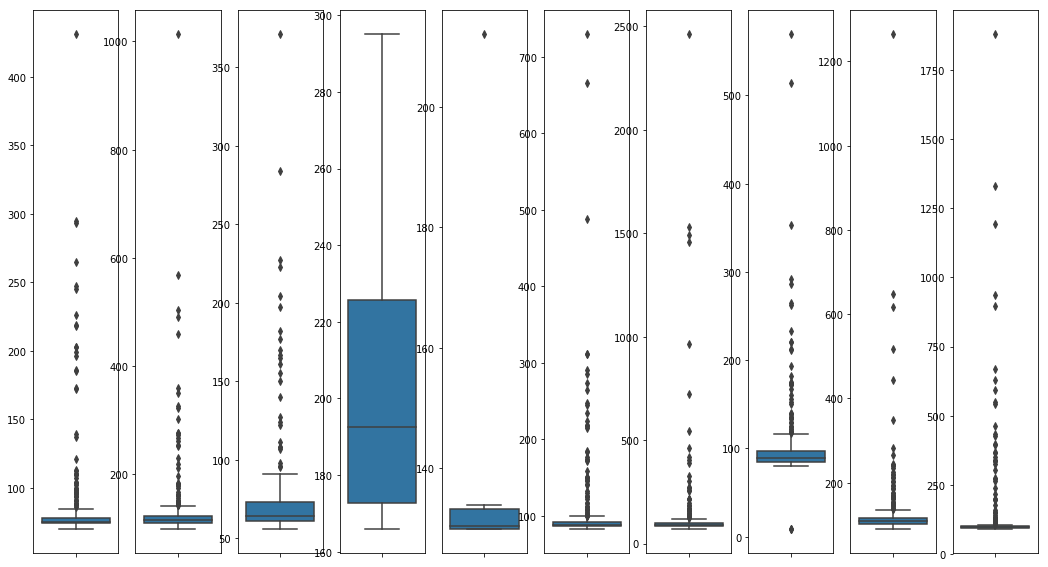

In [21]:
fig, axs = pyplot.subplots(figsize=(18,10), ncols=10)
for k, ax in zip(dset.keys(),axs):
    seaborn.boxplot(dset[k], orient='v', ax=ax)

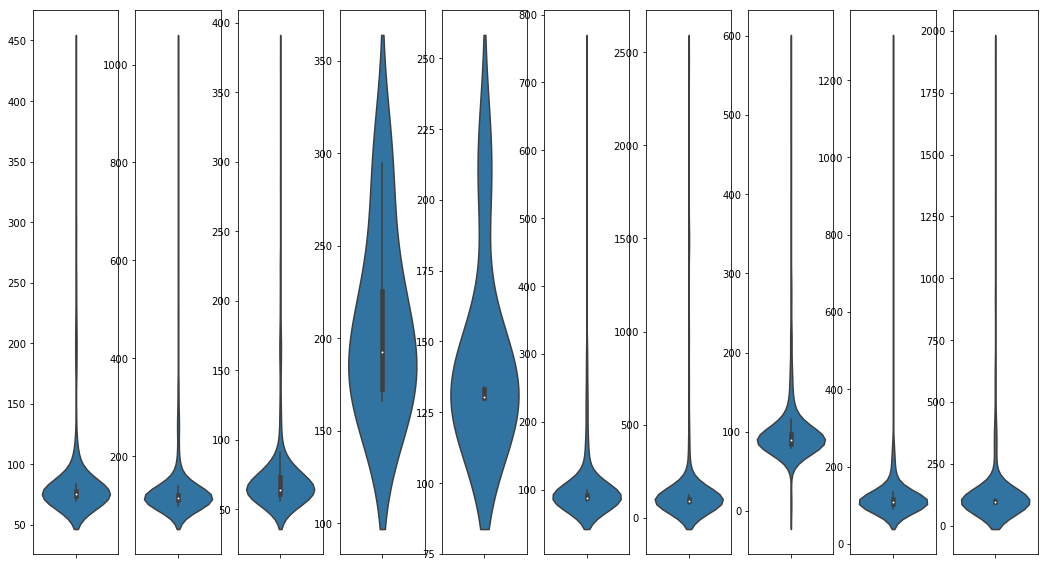

In [24]:
fig, axs = pyplot.subplots(figsize=(18,10), ncols=10)
for k, ax in zip(dset.keys(),axs):
    seaborn.violinplot(dset[k], orient='v', ax=ax)

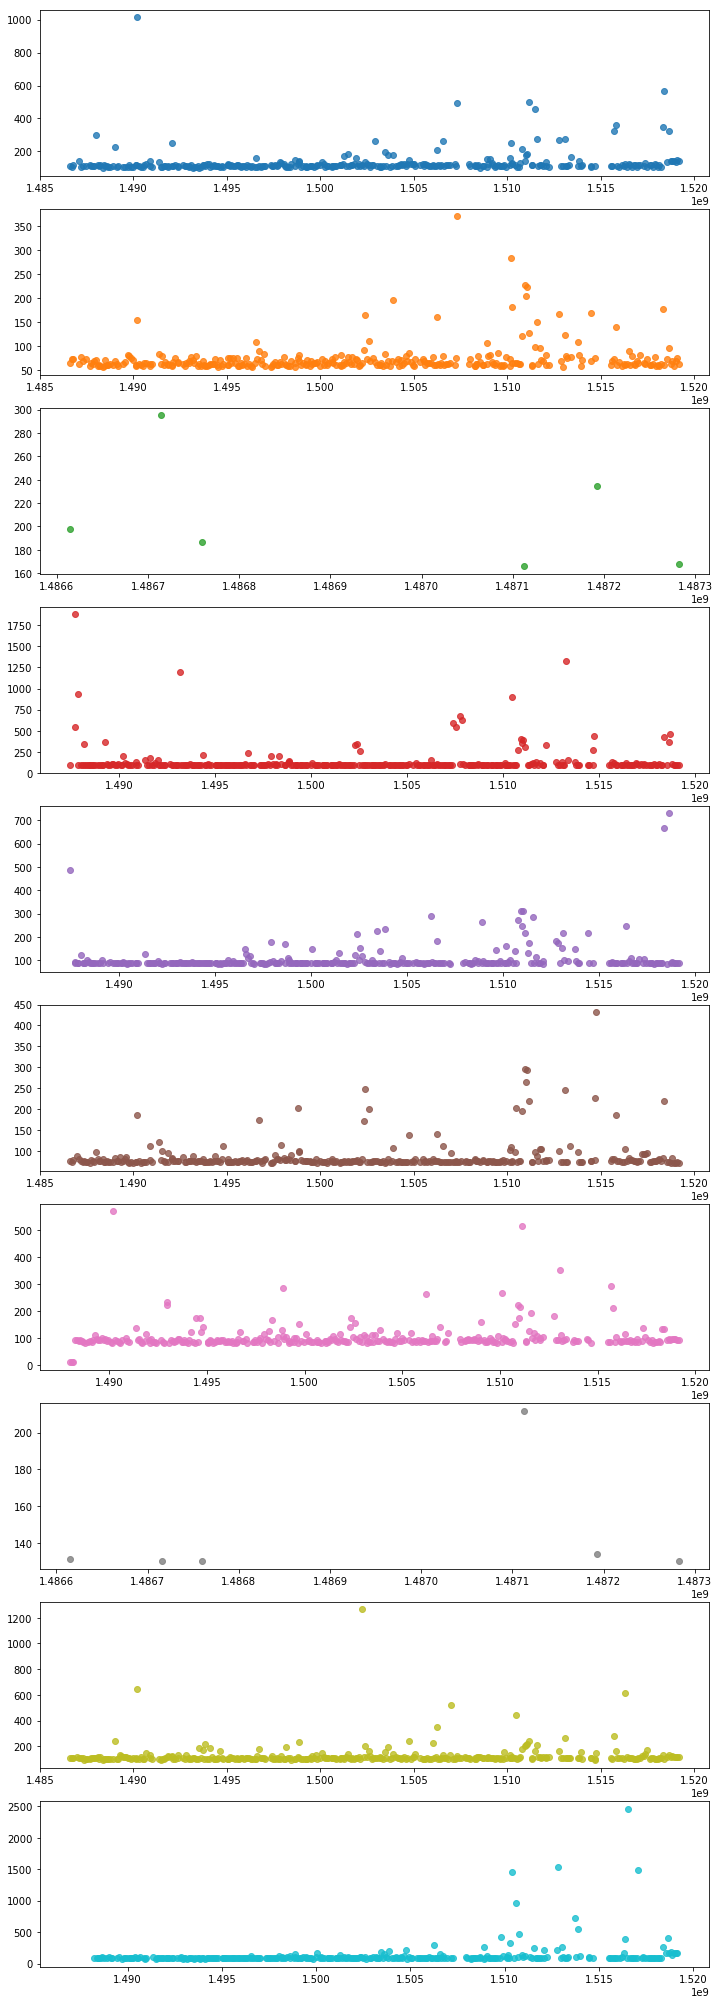

In [63]:
fig, axs = pyplot.subplots(figsize=(12,36), nrows=10)
for k, ax in zip(dset.keys(),axs):
    x = numpy.array(dset_stime[k])
    y = numpy.array(dset[k])
    seaborn.regplot(x=x, y=y, fit_reg=False, ax=ax)

In [13]:
sc.stop()

In [14]:
rc = stop_spark(jobid)
if rc != 0:
    print("Stopping Spark failed: ", rc)
else:
    print("Complete")

Complete
